In [20]:
import pandas as pd

sheet_names = ['JAN','FEB','MAR','APR','MAY','JUNE','JULY','AUG','SEP','OCT','NOV','DEC']
columns = ['DATE'
           ,'INT ARRIVALS 04','INT ARRIVALS 22','INT ARRIVALS TTL'
           ,'INT DEPARTURES 04','INT DEPARTURES 22','INT DEPARTURES TTL'
           ,'TRANSIT','NA1'
           ,'LOCAL G/A','LOCAL STATE','LOCAL T/G','NA2'
           ,'INTERNATIONAL TTL','TRANSIT TTL','LOCAL TTL'
           ,'Grant Total'
           ,'YEAR'
           ,'MONTH']


sheets = []
for y in ([2020,2021]):
    for m in sheet_names:
        twk = pd.read_excel('LARNAKA AIRPORT DAILY AIR TRAFFIC '+str(y)+'.xlsx', usecols = 'A:Q',skiprows = 6, header=0, sheet_name = m)
        twk['YEAR'] = y
        twk['MONTH'] = m
        twk.columns = columns
        #twk = twk.set_index('DATE')
        sheets.append(twk)

workbook = pd.concat(sheets, axis=0)
workbook

,DATE,INT ARRIVALS 04,INT ARRIVALS 22,INT ARRIVALS TTL,INT DEPARTURES 04,INT DEPARTURES 22,INT DEPARTURES TTL,TRANSIT,NA1,LOCAL G/A,LOCAL STATE,LOCAL T/G,NA2,INTERNATIONAL TTL,TRANSIT TTL,LOCAL TTL,Grant Total,YEAR,MONTH
0,1,10.0,38.0,48.0,11.0,36.0,47.0,2.0,NaN,0.0,0.0,0.0,NaN,95.0,2.0,0.0,97.0,2020,JAN
1,2,4.0,60.0,64.0,2.0,63.0,65.0,1.0,NaN,4.0,1.0,1.0,NaN,129.0,1.0,5.0,135.0,2020,JAN
2,3,0.0,55.0,55.0,1.0,53.0,54.0,2.0,NaN,2.0,1.0,7.0,NaN,109.0,2.0,3.0,114.0,2020,JAN
3,4,0.0,67.0,67.0,0.0,66.0,66.0,2.0,NaN,13.0,0.0,18.0,NaN,133.0,2.0,13.0,148.0,2020,JAN
4,5,0.0,63.0,63.0,22.0,63.0,85.0,0.0,NaN,4.0,1.0,0.0,NaN,148.0,0.0,5.0,153.0,2020,JAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,28,36.0,5.0,41.0,41.0,0.0,41.0,0.0,NaN,11.0,2.0,24.0,NaN,82.0,0.0,12.0,94.0,2021,DEC
28,29,47.0,0.0,47.0,52.0,0.0,52.0,0.0,NaN,8.0,0.0,18.0,NaN,99.0,0.0,10.0,109.0,2021,DEC
29,30,30.0,23.0,53.0,28.0,23.0,51.0,0.0,NaN,1.0,0.0,0.0,NaN,104.0,0.0,1.0,105.0,2021,DEC
30,31,24.0,9.0,33.0,23.0,13.0,36.0,0.0,NaN,0.0,0.0,0.0,NaN,69.0,0.0,0.0,69.0,2021,DEC


In [21]:
workbook = workbook.copy()
workbook['MONTH'] = workbook['MONTH'].apply(lambda x: 'JUN' if x=='JUNE' else x)
workbook['MONTH'] = workbook['MONTH'].apply(lambda x: 'JUL' if x=='JULY' else x)
workbook = workbook.loc[workbook['DATE'] != 'TTL']
workbook['DATE_FORMAT'] = (workbook['DATE'].astype(str) + '-' + workbook['MONTH'].astype(str) + '-' + workbook['YEAR'].astype(str))
workbook['DATE_FORMAT'] = pd.to_datetime(workbook['DATE_FORMAT'], format='%d-%b-%Y', infer_datetime_format=True, errors='coerce')
workbook = workbook.loc[~workbook['DATE_FORMAT'].isna()]
workbook = workbook.set_index('DATE_FORMAT')

In [22]:
workbook.to_csv('LARNAKA AIRPORT DAILY AIR TRAFFIC_2020-2021.csv', header=True)
workbook['Grant Total'].to_csv('LARNAKA AIRPORT DAILY AIR TRAFFIC_2020-2021 TOTAL.csv', header=True)

In [23]:
# add visualization libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
## use this custom funtion to for better view
def decompose(df, share_type='amount', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, model='additive', period=period) #[share_type]
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], model='additive', period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. 
    #Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

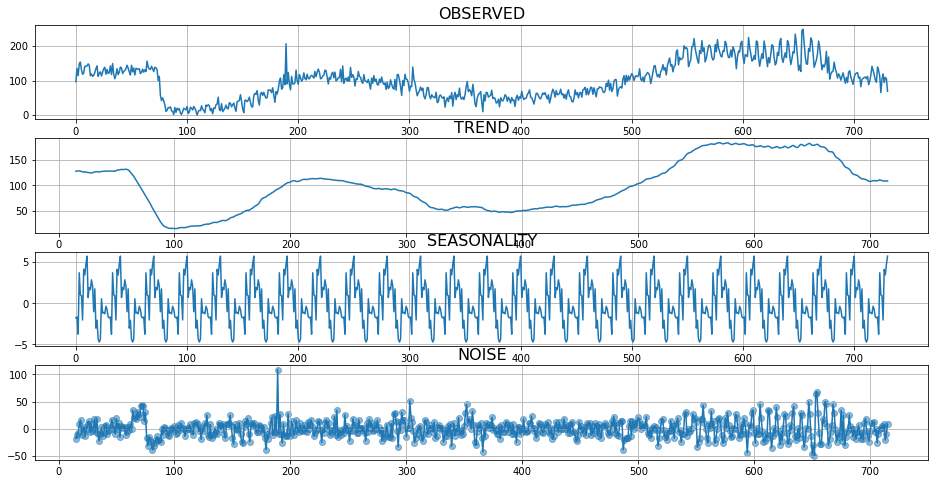

In [24]:
df = workbook['Grant Total'].reset_index().set_index('DATE_FORMAT').copy()
decompose(df,'Grant Total', 'all', 30)